
🚦 **Explorando Modelos de Regressão Poisson para Previsão de Contagem** 🚦

Acabei de publicar um novo notebook no GitHub onde aplico o modelo de regressão Poisson para analisar padrões de infrações de trânsito em Nova York. Este estudo foca nos veículos dos corpos diplomáticos estacionados próximos à sede da ONU.

🔍 **Objetivo do Estudo:**
O principal objetivo é entender como a implementação de uma lei que pune infrações de trânsito impactou a frequência dessas infrações. Analisamos dados antes e depois da introdução desta legislação.

📊 **Variáveis Preditivas:**
- **Índice de Corrupção dos Países:** Como a corrupção pode influenciar comportamentos de não conformidade.
- **Criação da Lei:** A introdução legal é um divisor no comportamento do corpo diplomático.
- **Quantidade de Membros Diplomáticos:** Mais pessoas podem significar mais infrações.

🧮 **Por que o Modelo Poisson?**
O modelo de regressão Poisson é ideal para prever a contagem de eventos que ocorrem em um determinado intervalo de tempo ou espaço. Ele nos ajuda a estimar a frequência de infrações com base nas variáveis preditivas mencionadas.


##### Importar bibliotecas

In [19]:

import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
from math import exp, factorial # funções matemáticas 'exp' e 'factorial'
import statsmodels.api as sm # estimação de modelos
import statsmodels.formula.api as smf # estimação de modelos de contagem
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson
# pacote acima para a estimação dos modelos ZINB e ZIP, respectivamente
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
# pacote anterior para a realização do teste de Vuong
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import warnings
warnings.filterwarnings('ignore')


Dados oriundos do estudo abaixo

Fisman, R.; Miguel, E. Corruption, Norms, and Legal Enforcement: Evidence
from Diplomatic Parking Tickets.

Journal of Political Economy, v. 15, n. 6, p. 1020-1048, 2007.
https://www.journals.uchicago.edu/doi/abs/10.1086/527495

o questionamento é sobre se aspectos culturais influenciam uma maior ou menor propensão a corrupção

a maneira de encontrar pessoas do mundo inteiro e um mesmo lugar sofrendo as mesmas penalidades foi ao redor da ONU em Nova Iorque

e os membros do corpo diplomático sofrem as mesmas influencias de normas no que diz respeito a estacionamento em local proibido

E até 2001, membros de corpo diplomático em Nova Iorque não sofriam multas

A partir de 2002, mudaram a legislação e passaram a cobrar multas de estacionamento em locais proibidos mesmo sendo membro de corpo diplomático

In [20]:
# dados
df_corruption = pd.read_csv('corruption.csv', delimiter=',')
df_corruption

,country,code,violations,staff,post,corruption
0,Angola,AGO,50,9,no,1.047506
1,Angola,AGO,1,9,yes,1.047506
2,Albania,ALB,17,3,no,0.921079
3,Albania,ALB,0,3,yes,0.921079
4,United Arab Emirates,ARE,0,3,no,-0.779468
...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807
294,Zambia,ZMB,37,9,no,0.562193
295,Zambia,ZMB,0,9,yes,0.562193
296,Zimbabwe,ZWE,43,14,no,0.133379


Violations é a quantidade de violações, variável Y

Staff é a quantidade de membros do corpo diplomático

Post é a variável dummy antes ou depois da lei (NO é antes da lei, YES é depois da lei)

Corruption é o índice da transparência internacional. Quando maior o índice pior


### Modelo de Regressão Poisson

A equação do modelo é:

$$
\ln(\text{violations}) = \alpha + \beta_1 \times \text{staff} + \beta_2 \times \text{post(yes=1)} + \beta_3 \times \text{corruption}
$$

In [21]:
# característica das variáveis
df_corruption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     298 non-null    object 
 1   code        298 non-null    object 
 2   violations  298 non-null    int64  
 3   staff       298 non-null    int64  
 4   post        298 non-null    object 
 5   corruption  298 non-null    float64
dtypes: float64(1), int64(2), object(3)
memory usage: 14.1+ KB


In [22]:
# estatística das variáveis
df_corruption.describe()

,violations,staff,corruption
count,298.000000,298.000000,298.000000
mean,6.496644,11.805369,0.013641
std,18.210377,11.079558,1.012474
min,0.000000,2.000000,-2.582988
25%,0.000000,6.000000,-0.415147
50%,0.000000,9.000000,0.326959
75%,3.000000,14.000000,0.720250
max,167.000000,86.000000,1.582807


In [23]:
# criar tabela de frequência da variável violations
contagem = df_corruption['violations'].value_counts(dropna=False)
percent = (df_corruption['violations'].value_counts(dropna=False, normalize=True)*100).round(2)
table = pd.concat([contagem, percent], axis=1, keys=['contagem','%'], sort=True)
table

,contagem,%
violations,,
0,156,52.35
1,35,11.74
2,16,5.37
3,17,5.70
4,5,1.68
5,10,3.36
6,3,1.01
7,4,1.34
8,3,1.01


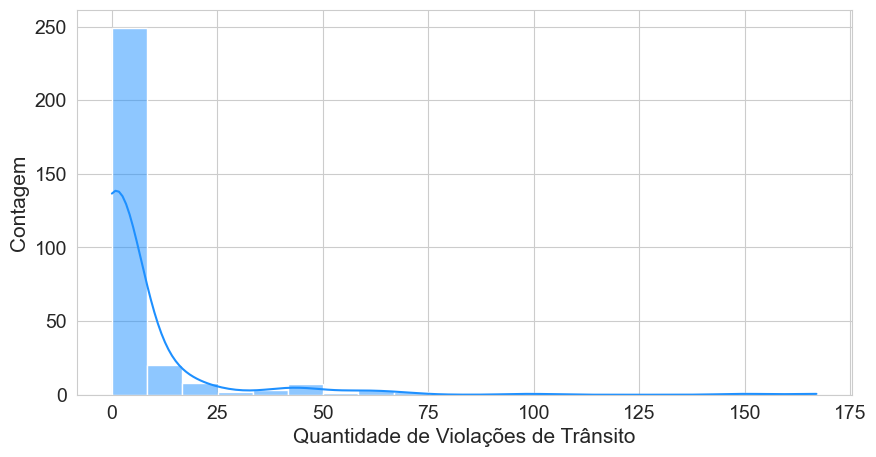

In [24]:
# criar histograma da variável dependente violations
with sns.axes_style("whitegrid"):
    plt.figure(figsize=(10,5))
    sns.histplot(data=df_corruption, x='violations', bins=20,
    color='dodgerblue', edgecolor='white', kde=True)
    plt.xlabel('Quantidade de Violações de Trânsito', fontsize=15)
    plt.ylabel('Contagem', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [25]:
# diagnóstico preliminar para observação de eventual igualdade entre a média e variância da variável dependente violations
pd.DataFrame({'média':[df_corruption.violations.mean()],
'Variância':[df_corruption.violations.var()]})

,média,Variância
0,6.496644,331.617834


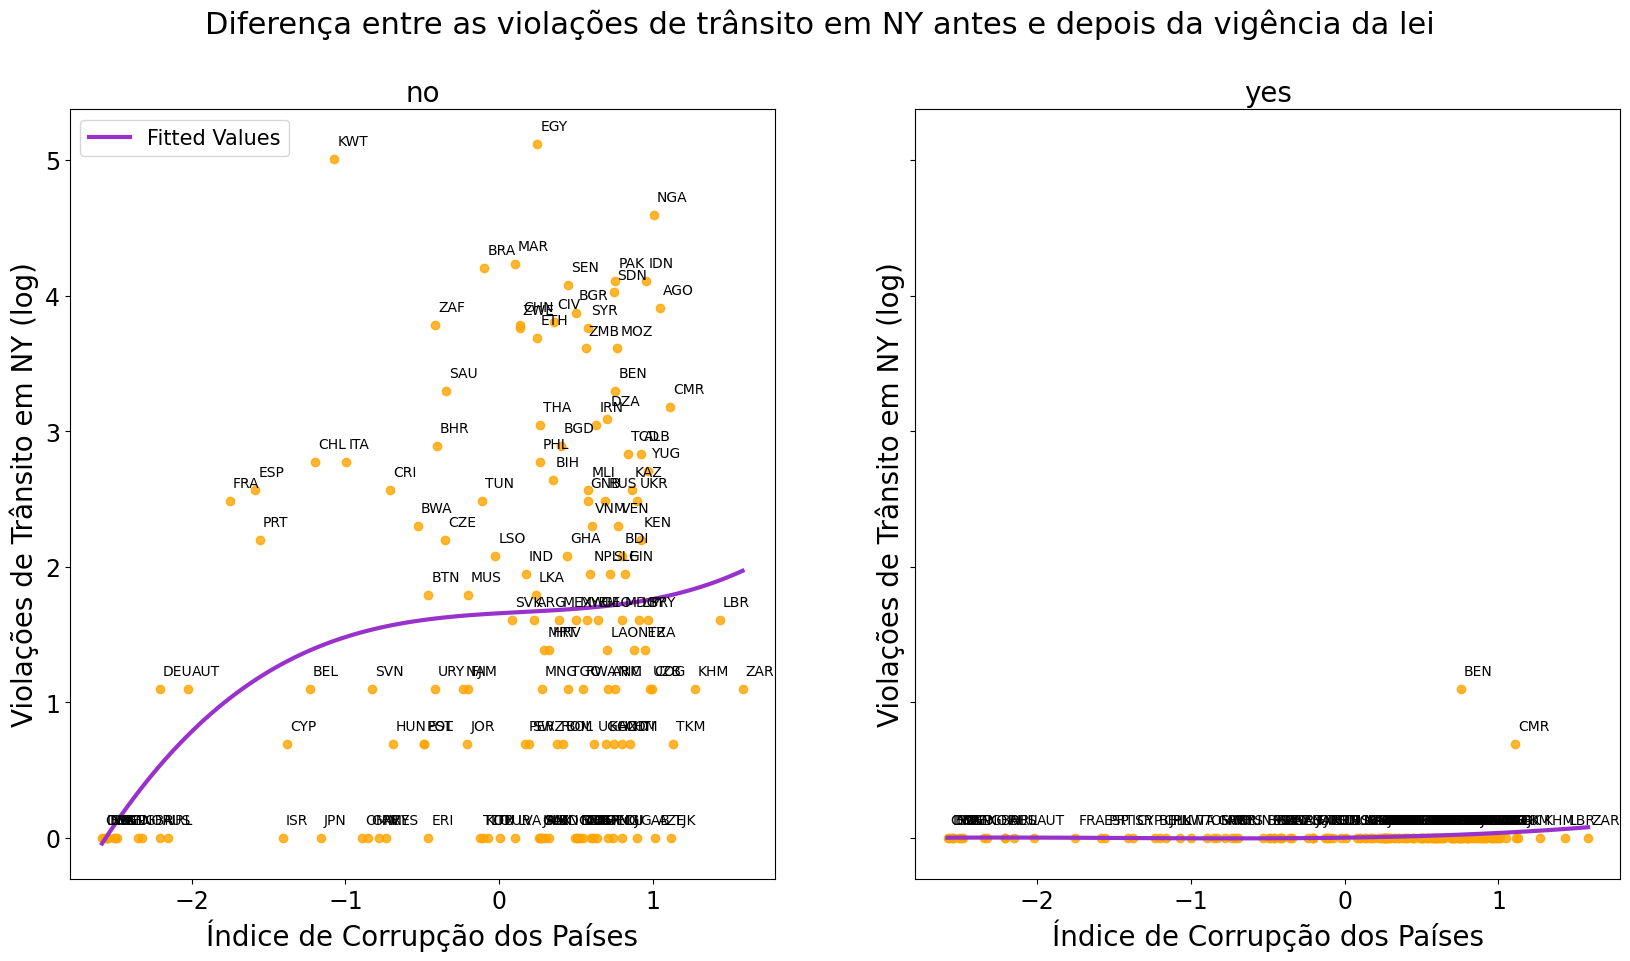

In [26]:
# comportamento das variáveis corruption e violation antes e depois do início da vigência da lei

fig, axs = plt.subplots(ncols=2, figsize=(20,10), sharey=True)

fig.suptitle('Diferença entre as violações de trânsito em NY antes e depois da vigência da lei',
             fontsize=22)

post = ['no', 'yes']

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y']+.1, str(point['val']))

for i, v in enumerate(post):
    df = df_corruption[df_corruption.post==v]
    df['violations'] = np.log(df.violations)
    df.loc[df['violations'] == np.inf, 'violations'] = 0
    df.loc[df['violations'] == -np.inf, 'violations'] = 0
    sns.regplot(data=df, x='corruption', y='violations',
                order=3, ax=axs[i], ci=False,
                line_kws={'color':'darkorchid', 'linewidth': 3,
                          'label':'Fitted Values'},
                scatter_kws={'color':'orange'})
    axs[i].set_title(v, fontsize=20)
    axs[i].set_ylabel("Violações de Trânsito em NY (log)", fontsize=20)
    axs[i].set_xlabel("Índice de Corrupção dos Países", fontsize=20)
    label_point(df.corruption, df.violations, df.code, axs[i])

for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=17)
    
axs[0].legend(loc='upper left', fontsize=15)

plt.show()

In [27]:
# estimação do modelo poisson 
modelo_poisson = smf.glm(formula='violations ~ staff + post + corruption',
                        data=df_corruption,
                        family=sm.families.Poisson()).fit()

# parâmetros do modelo
print(modelo_poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             violations   No. Observations:                  298
Model:                            GLM   Df Residuals:                      294
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2071.8
Date:                Sun, 06 Oct 2024   Deviance:                       3644.0
Time:                        19:25:24   Pearson chi2:                 6.77e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2127      0.031     71.134      

A variável post em sua essência deveria ser transformada em dummy. 

Porém, como ele é uma variável dicotomica e está em ordem alfabética (NO vem antes do YES). 

O modelo vai chamar a variável post de yes e nós queremos que o yes seja dummy = 1.

Todos os parâmetros possuem significância estatística, considerando um nível de significância de 5%

Porém, podemos afirmar que a estimação Poisson é a mais adequada?

Vamos rodar o teste de Cameron e Trivedi para verificar a exisitência de superdispersão


##### Teste Cameron e Trivedi

In [28]:
# adicionando os fitted values do modelo Poisson ao dataframe
df_corruption['lambda_poisson'] = modelo_poisson.fittedvalues
df_corruption

,country,code,violations,staff,post,corruption,lambda_poisson
0,Angola,AGO,50,9,no,1.047506,15.919915
1,Angola,AGO,1,9,yes,1.047506,0.216711
2,Albania,ALB,17,3,no,0.921079,13.371720
3,Albania,ALB,0,3,yes,0.921079,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915
...,...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807,0.243691
294,Zambia,ZMB,37,9,no,0.562193,13.486751
295,Zambia,ZMB,0,9,yes,0.562193,0.183589
296,Zimbabwe,ZWE,43,14,no,0.133379,12.994217


In [29]:
# criar a variável Y*
df_corruption['ystar'] = (((df_corruption['violations'] - df_corruption['lambda_poisson'])**2) - df_corruption['violations'])/df_corruption['lambda_poisson']
df_corruption

,country,code,violations,staff,post,corruption,lambda_poisson,ystar
0,Angola,AGO,50,9,no,1.047506,15.919915,69.815208
1,Angola,AGO,1,9,yes,1.047506,0.216711,-1.783289
2,Albania,ALB,17,3,no,0.921079,13.371720,-0.286843
3,Albania,ALB,0,3,yes,0.921079,0.182023,0.182023
4,United Arab Emirates,ARE,0,3,no,-0.779468,7.477915,7.477915
...,...,...,...,...,...,...,...,...
293,Zaire,ZAR,0,6,yes,1.582807,0.243691,0.243691
294,Zambia,ZMB,37,9,no,0.562193,13.486751,38.250347
295,Zambia,ZMB,0,9,yes,0.562193,0.183589,0.183589
296,Zimbabwe,ZWE,43,14,no,0.133379,12.994217,65.979120


In [30]:
# estimar o modelo auxiliar OLS, sem o intercepto
modelo_auxiliar = sm.OLS.from_formula('ystar ~ 0 + lambda_poisson',
                                    df_corruption).fit()

# parâmetros do modelo auxiliar
print(modelo_auxiliar.summary()) 

                                 OLS Regression Results                                
Dep. Variable:                  ystar   R-squared (uncentered):                   0.025
Model:                            OLS   Adj. R-squared (uncentered):              0.022
Method:                 Least Squares   F-statistic:                              7.584
Date:                Sun, 06 Oct 2024   Prob (F-statistic):                     0.00625
Time:                        19:25:24   Log-Likelihood:                         -1952.9
No. Observations:                 298   AIC:                                      3908.
Df Residuals:                     297   BIC:                                      3911.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

caso o p-value do parâmetro de lambda_poisson seja maior que o 0.05

verifica-se a existência de equidispersão nos dados

caso contrário, verifica-se a existência de superdispersão nos dados, fato que favorecerá a estimação de um modelo binomial negativo, como ocorre nesse caso

In [31]:
# Uma abordagem mais direta para a detecção da superdispersão pelo Teste de
#Cameron e Trivedi (1990) é por meio da utilização da função 'overdisp' do
#pacote 'statstests.tests'

# Instalação e carregamento da função 'overdisp' do pacote 'statstests.tests'
# Autores do pacote: Luiz Paulo Fávero e Helder Prado Santos
# https://stats-tests.github.io/statstests/

from statstests.tests import overdisp

In [32]:
# elaboração direta do teste de superdispersão
overdisp(modelo_poisson, df_corruption)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.022    
Dependent Variable:     ystar            AIC:                         3907.7809
Date:                   2024-10-06 19:25 BIC:                         3911.4780
No. Observations:       298              Log-Likelihood:              -1952.9  
Df Model:               1                F-statistic:                 7.584    
Df Residuals:           297              Prob (F-statistic):          0.00625  
R-squared (uncentered): 0.025            Scale:                       28915.   
-------------------------------------------------------------------------------------
            Coef.        Std.Err.         t          P>|t|        [0.025       0.975]
-------------------------------------------------------------------------------------
lmbda       2.6525         0.9632       2.7538       0.0063       0.7569       4.5480
-------------